#### *Applied Mathematical Finance 2*

## <ins> *Seminar 2: Equity Derivatives I* </ins>

### 1. Black formula

The Black's formula gives a closed-form formula to value European vanilla option with given strike $K$ and expiration time $T$. Given the forward $F(t, T)$ and the implied volatility $\sigma(T, K)$, the present value of the call/put with strike $K$ and expiration time $T$ is given by

$$PV_t = DF(t, T) \cdot \theta \cdot \left[ F(t, T) \cdot \Phi(\theta \cdot d_{+}) - K \cdot \Phi(\theta \cdot d_{-})\right],$$

where 
$$
d_{+} = \frac{\ln(F(t, T) / K) + (\sigma^2(T, K)/2)(T - t)}{\sigma \sqrt{T - t}},  \quad d_{-} = d_{+} - \frac{\sigma \sqrt{T - t}}{2},
$$

$\theta = \pm 1$ for calls and puts respectively, $DF(t, T)$ is a discount factor from $T$ to $t$. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Any, Union
from scipy.stats import norm
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
def black_price_formula(F: float,
                        K: Union[float, np.ndarray],
                        T: float,
                        sigma: Union[float, np.ndarray],
                        isCall: bool = True,
                        df: float = 1) -> Union[float, np.ndarray]:
    """Pricing formula from Black76. Broadcasts in both forward and strike.

    Args:
        F: forward.
        K: grid of strikes.
        T: tenor.
        sigma: implied volatility.
        isCall: type of option (True if Call, False if Put).
        df: discount factor. 

    Returns 2D array in spot (rows) and strikes (columns) grid.
    """
    if isinstance(K, (float, int)):
        assert isinstance(sigma, (float, int)), "K and sigma should both either floats or np.ndarrays"
    elif isinstance(K, np.ndarray):
        assert isinstance(sigma, np.ndarray), "K and sigma should both either floats or np.ndarrays"
    else:
        raise TypeError("K and sigma should both either floats or np.ndarrays")
    
    stddev = sigma * np.sqrt(T)
    d1 = np.log(F / K) / stddev + 0.5 * stddev
    d2 = d1 - stddev
    theta = 1.0 if isCall else -1.0
    return df * theta * (F * norm.cdf(theta * d1) - K * norm.cdf(theta * d2))

##### 1.1 Data extraction

In [3]:
spx_data = pd.read_csv("data/ImpliedVol_SPX.csv", sep=";")
forw_and_dfs = pd.read_csv("data/ForwardsAndDFs_SPX.csv")

In [4]:
spx_data.head()

,Unnamed: 0.1,Unnamed: 0,Unnamed: 1,Strike,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,0,Periods,Date,2000.000000,2100.000000,2300.000000,2700.000000,3200.000000,3500.000000,3700.000000,4000.000000,4300.000000,4500.000000,4900.000000,5300.000000,5900.0,6300.0,6800.0,7300.0
1,1,1M,05/09/2021,NaN,NaN,NaN,NaN,NaN,0.255031,0.229717,0.184537,0.142742,0.120222,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2M,05/10/2021,NaN,NaN,NaN,NaN,0.290835,0.258944,0.230097,0.186557,0.147864,0.126235,0.102493,NaN,NaN,NaN,NaN,NaN
3,3,3M,05/11/2021,NaN,NaN,NaN,0.332682,0.296949,0.257722,0.229462,0.189104,0.153375,0.132963,0.107623,0.100413,NaN,NaN,NaN,NaN
4,4,6M,05/02/2022,0.386117,0.382065,0.374263,0.348532,0.288763,0.250947,0.227014,0.193942,0.164735,0.147584,0.122567,0.111081,NaN,NaN,NaN,NaN


In [5]:
forw_and_dfs.head()

,Date,Forwards,DF
0,12/08/2021,4405.261308,0.999976
1,13/08/2021,4405.182332,0.999972
2,14/08/2021,4405.221366,0.999969
3,15/08/2021,4405.260400,0.999965
4,16/08/2021,4404.494415,0.999962


In [6]:
# Extract volatility data

strikes = spx_data.iloc[0, 3:].values.astype(float)
volatilities = spx_data.iloc[1:, 3:].values.astype(float)
dates = spx_data.iloc[1:, 2].values
periods = spx_data.iloc[1:, 1].values

In [7]:
# Extract forwards and discount factors

forwards = dict(zip(forw_and_dfs["Date"], forw_and_dfs["Forwards"]))
dfs = dict(zip(forw_and_dfs["Date"], forw_and_dfs["DF"]))

In [8]:
# Value date info

value_date = "05/08/2021" # value date, i.e. date at which all market data above is observed
S = 4406.97 # .SPX close spot quote on 05/08/2021

##### 1.2 Data visualization

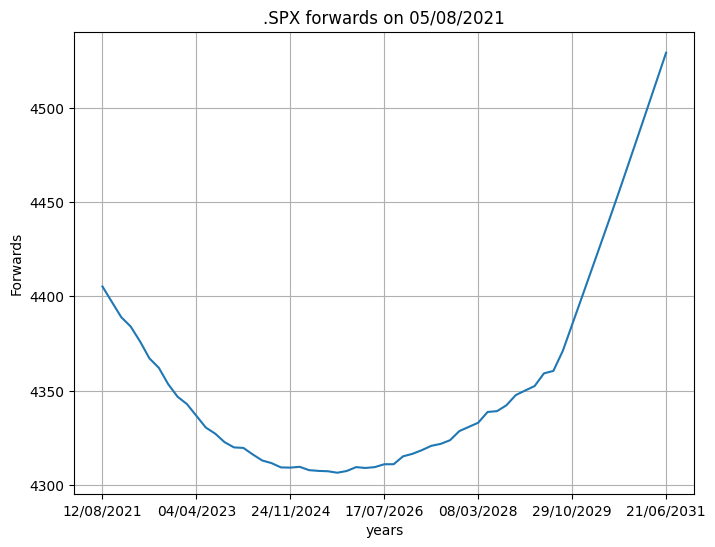

In [9]:
window = 60 # extract forward appeoximately on each 60 days
dates_plot = forw_and_dfs["Date"][::window]
dates_ticks = forw_and_dfs["Date"][:: window * 10]
forwards_plot = forw_and_dfs["Forwards"][::60]
dfs_plot = forw_and_dfs["DF"][::60]

plt.figure(figsize=(8, 6))
plt.title(".SPX forwards on {}".format(value_date))
plt.plot(dates_plot, forwards_plot)
plt.xlabel("years")
plt.xticks(dates_ticks)
plt.ylabel("Forwards")
plt.grid()
plt.show()

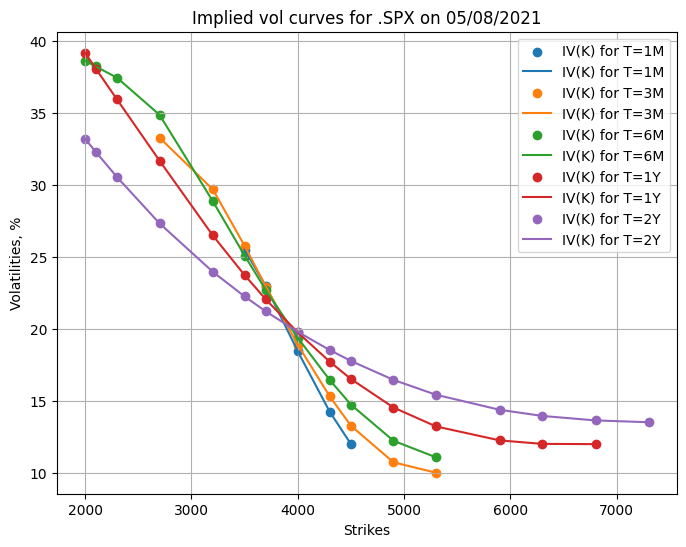

In [10]:
plt.figure(figsize=(8, 6))
periods_to_plot = ["1M", "3M", "6M", "1Y", "2Y"]
for period_to_plot in periods_to_plot:
    index_of_period = np.where(periods == period_to_plot)[0][0]
    volatilities_per_period = volatilities[index_of_period]
    nont_null_vol_mask = ~np.isnan(volatilities_per_period)
    selected_strikes = strikes[nont_null_vol_mask]
    selected_vols = volatilities_per_period[nont_null_vol_mask]
    plt.scatter(selected_strikes, selected_vols * 100, label="IV(K) for T={}".format(period_to_plot))
    plt.plot(selected_strikes, selected_vols * 100, label="IV(K) for T={}".format(period_to_plot))

plt.title("Implied vol curves for .SPX on {}".format(value_date))
plt.xlabel("Strikes")
plt.ylabel("Volatilities, %")
plt.grid()
plt.legend()
plt.show()

##### 1.3 Options pricing

In [11]:
def get_strikes_and_vols_per_period(period: str, volatilities: np.ndarray, strikes: np.ndarray, periods: np.ndarray):
    """
    Returns the strikes and corresponding volatilities per given period.
    """
    index_of_period = np.where(periods == period)[0][0]
    volatilities_per_period = volatilities[index_of_period]
    nont_null_vol_mask = ~np.isnan(volatilities_per_period)
    return strikes[nont_null_vol_mask], volatilities_per_period[nont_null_vol_mask]


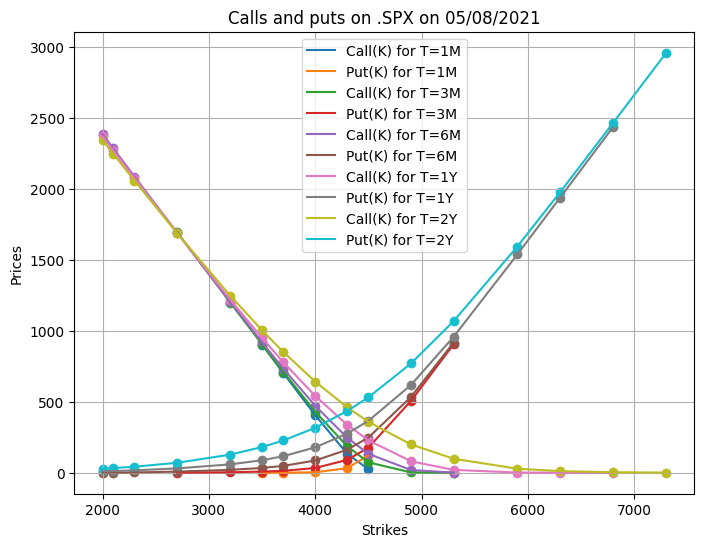

In [12]:
plt.figure(figsize=(8, 6))
periods_to_plot = ["1M", "3M", "6M", "1Y", "2Y"]
expirations = np.array([1, 3, 6, 12, 24]) / 12
for i, period_to_plot in enumerate(periods_to_plot):
    selected_strikes, selected_vols = get_strikes_and_vols_per_period(period=period_to_plot, volatilities=volatilities, strikes=strikes, periods=periods)

    index_of_period = np.where(periods == period_to_plot)[0][0]
    date = dates[index_of_period]
    forward, df = forwards[date], dfs[date]
    expiration = expirations[i]
    
    calls_prices = black_price_formula(F=forward, K=selected_strikes, T=expiration, sigma=selected_vols, isCall=True, df=df)
    put_prices = black_price_formula(F=forward, K=selected_strikes, T=expiration, sigma=selected_vols, isCall=False, df=df)

    plt.scatter(selected_strikes, calls_prices)
    plt.plot(selected_strikes, calls_prices, label="Call(K) for T={}".format(period_to_plot))
    plt.scatter(selected_strikes, put_prices)
    plt.plot(selected_strikes, put_prices, label="Put(K) for T={}".format(period_to_plot))

plt.title("Calls and puts on .SPX on {}".format(value_date))
plt.xlabel("Strikes")
plt.ylabel("Prices")
plt.grid()
plt.legend()
plt.show()

##### 1.4 Cubic vs monotone cubic splines

Cubic splines are by construction twice continuously differentiable => may lead to the spline function oscillating and ‘’overshooting’’ in between the data points. 

The **monotone** cubic interpolants are constructed to be only once continuously differentiable and attempt to preserve the local shape implied by the data. 

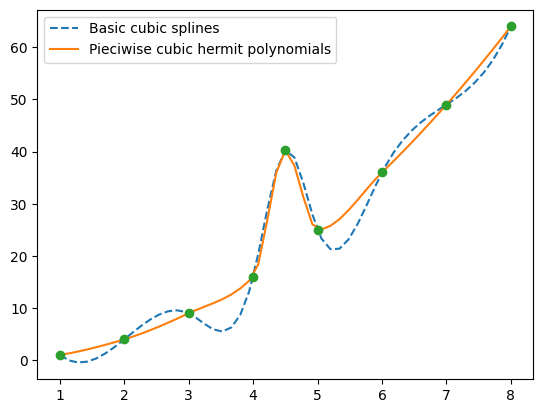

In [13]:
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator
x = np.array([1., 2., 3., 4., 4.5, 5., 6., 7., 8])
y = x ** 2
y[4] += 20

xx = np.linspace(1, 8, 51)
plt.plot(xx, CubicSpline(x, y)(xx), '--', label='Basic cubic splines')
plt.plot(xx, PchipInterpolator(x, y)(xx), '-', label='Pieciwise cubic hermit polynomials')
plt.plot(x, y, 'o')
plt.legend()
plt.show()

##### 1.5 Volatility interpolation

In [14]:
def volatility_interpolator(strikes: np.ndarray, volatilities: np.ndarray):
    """
    Returns the volatility interpolator.
    """
    # monotone cubic splines interpolator
    return PchipInterpolator(x=np.log(strikes), y=volatilities)

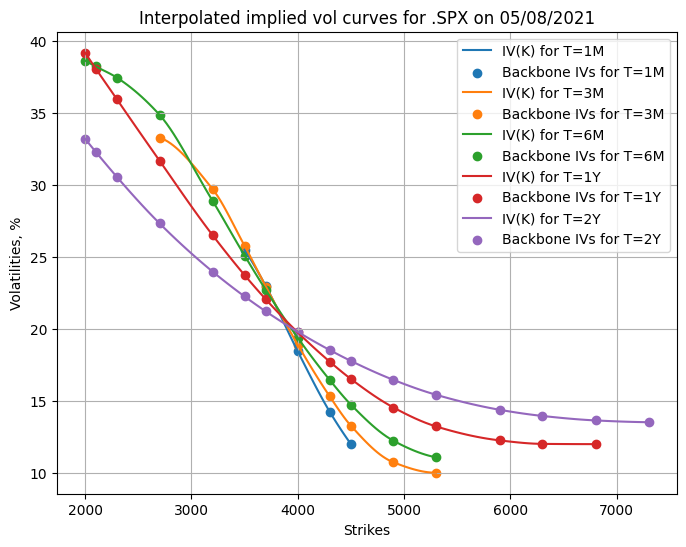

In [15]:
plt.figure(figsize=(8, 6))
periods_to_plot = ["1M", "3M", "6M", "1Y", "2Y"]
for period_to_plot in periods_to_plot:
    selected_strikes, selected_vols = get_strikes_and_vols_per_period(period=period_to_plot, volatilities=volatilities, strikes=strikes, periods=periods)
    vol_interpolator = volatility_interpolator(strikes=selected_strikes, volatilities=selected_vols) # monotone cubic splines interpolator
    
    strike_min, strike_max = np.min(selected_strikes), np.max(selected_strikes)
    high_frequency_strikes_grid = np.linspace(strike_min, strike_max, 100)
    
    plt.plot(high_frequency_strikes_grid, vol_interpolator(np.log(high_frequency_strikes_grid))* 100, label="IV(K) for T={}".format(period_to_plot))
    plt.scatter(selected_strikes, selected_vols * 100, label="Backbone IVs for T={}".format(period_to_plot))

plt.title("Interpolated implied vol curves for .SPX on {}".format(value_date))
plt.xlabel("Strikes")
plt.ylabel("Volatilities, %")
plt.grid()
plt.legend()
plt.show()

### 2. Digital options

The digital option is (probably) the most polular exotic derivative product. The payoff of the one with the strike $K$ and exoiration time $T$ is given by indicator function 


$$\mathbb{1} \{S_T > K\}.$$

Observing the prices $\{C(\tilde K)\}_{ \{ \tilde K: K - \varepsilon \leq \tilde K \leq K + \varepsilon \}}$ of vanilla call options (for a fixed expiration time $T$), the digital call option can be (model independently!) replicated with the (limit of) call spreads. That is, 

$$PV^{\text{digital call}}_t = \lim_{\varepsilon \to 0} \dfrac{C(K - \varepsilon) - C(K + \varepsilon)}{2 \varepsilon} = - \dfrac{dC(K)}{dK},$$


So, given the Black's formula and all its derivatives, can we easily put the price of the digital call equal to the Black's derivative with respect to strike, i.e. 

$$PV^{\text{digital call}}_t \stackrel{?}{=} - \dfrac{\partial \text{Black}(K)}{\partial K} \equiv DF(t, T) \Phi(d_{-}).$$

The answer is no and the reason is quite obvious. In the presence of volatility smile, the correct value is obtained from the following expansion

$$
\begin{align*}
PV^{\text{digital call}}_t = - \dfrac{dC(K, \sigma(K))}{dK} &= - \dfrac{\partial \text{Black}(K, \sigma(K))}{\partial K} - \dfrac{\partial \text{Black}(K, \sigma(K))}{\partial \sigma} \cdot \dfrac{\partial \sigma(K)}{\partial K} \\ \\
&= \text{Black}^{digital}(K) - \nu_{Black}(K, \sigma(K)) \cdot \text{Skew}(K) \\ \\
&= DF(t, T) \cdot \Phi(d_{-}) - F \cdot DF(t, T) \cdot \phi(d_{+}) \cdot \sqrt{T - t} \cdot \text{Skew}(K).
\end{align*}
$$



##### 2.1 Black digital price

As mentioned above, Black's digital price is

$$\text{Black}^{digital} (K) \stackrel{def}{=} - \dfrac{\partial \text{Black}(K, \sigma(K))}{\partial K} = DF(t, T) \cdot \Phi(d_-).$$

In [16]:
def black_digital(F: float,
                  K: Union[float, np.ndarray],
                  T: float,
                  sigma: Union[float, np.ndarray],
                  isCall: bool = True,
                  df: float = 1) -> Union[float, np.ndarray]:
    """Options delta in Black model.

    Args:
        F: forward.
        K: grid of strikes.
        T: tenor.
        sigma: implied volatility.
        isCall: type of option (True if Call, False if Put).
        df: discount factor. 

    """
    if isinstance(K, (float, int)):
        assert isinstance(sigma, (float, int)), "K and sigma should both either floats or np.ndarrays"
    elif isinstance(K, np.ndarray):
        assert isinstance(sigma, np.ndarray), "K and sigma should both either floats or np.ndarrays"
    else:
        raise TypeError("K and sigma should both either floats or np.ndarrays")
    
    stddev = sigma * np.sqrt(T)
    d1 = np.log(F / K) / stddev - 0.5 * stddev
    theta = 1.0 if isCall else -1.0
    return df * theta * norm.cdf(theta * d1)

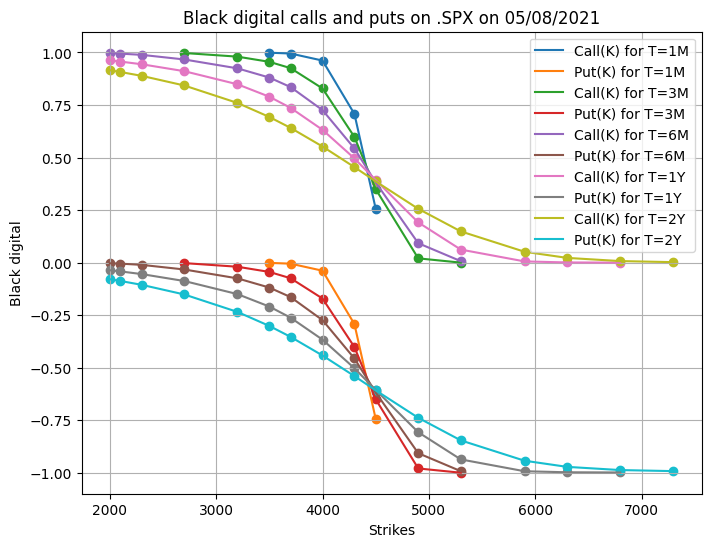

In [17]:
plt.figure(figsize=(8, 6))
periods_to_plot = ["1M", "3M", "6M", "1Y", "2Y"]
expirations = np.array([1, 3, 6, 12, 24]) / 12
for i, period_to_plot in enumerate(periods_to_plot):
    selected_strikes, selected_vols = get_strikes_and_vols_per_period(period=period_to_plot, volatilities=volatilities, strikes=strikes, periods=periods)

    index_of_period = np.where(periods == period_to_plot)[0][0]
    date = dates[index_of_period]
    forward, df = forwards[date], dfs[date]
    expiration = expirations[i]
    
    calls_deltas = black_digital(F=forward, K=selected_strikes, T=expiration, sigma=selected_vols, isCall=True, df=df)
    put_deltas = black_digital(F=forward, K=selected_strikes, T=expiration, sigma=selected_vols, isCall=False, df=df)

    plt.scatter(selected_strikes, calls_deltas)
    plt.plot(selected_strikes, calls_deltas, label="Call(K) for T={}".format(period_to_plot))
    plt.scatter(selected_strikes, put_deltas)
    plt.plot(selected_strikes, put_deltas, label="Put(K) for T={}".format(period_to_plot))

plt.title("Black digital calls and puts on .SPX on {}".format(value_date))
plt.xlabel("Strikes")
plt.ylabel("Black digital")
plt.grid()
plt.legend()
plt.show()

##### 2.2 Black vega

Again, Black's vega is

$$\dfrac{\partial \text{Black}(K, \sigma(K))}{\partial \sigma} \stackrel{\text{def}}{=} \nu_{Black}(K, \sigma(K)) = F \cdot DF(t, T) \cdot \phi(d_+) \cdot \sqrt{T - t}.$$

In [18]:
def black_vega(F: float,
               K: Union[float, np.ndarray],
               T: float,
               sigma: Union[float, np.ndarray],
               df: float = 1) -> Union[float, np.ndarray]:
    """Options vega in Black model.

    Args:
        F: forward.
        K: grid of strikes.
        T: tenor.
        sigma: implied volatility.
        isCall: type of option (True if Call, False if Put).
        df: discount factor. 

    """
    if isinstance(K, (float, int)):
        assert isinstance(sigma, (float, int)), "K and sigma should both either floats or np.ndarrays"
    elif isinstance(K, np.ndarray):
        assert isinstance(sigma, np.ndarray), "K and sigma should both either floats or np.ndarrays"
    else:
        raise TypeError("K and sigma should both either floats or np.ndarrays")
    
    stddev = sigma * np.sqrt(T)
    d1 = np.log(F / K) / stddev + 0.5 * stddev
    return df * F * norm.pdf(d1) * np.sqrt(T)

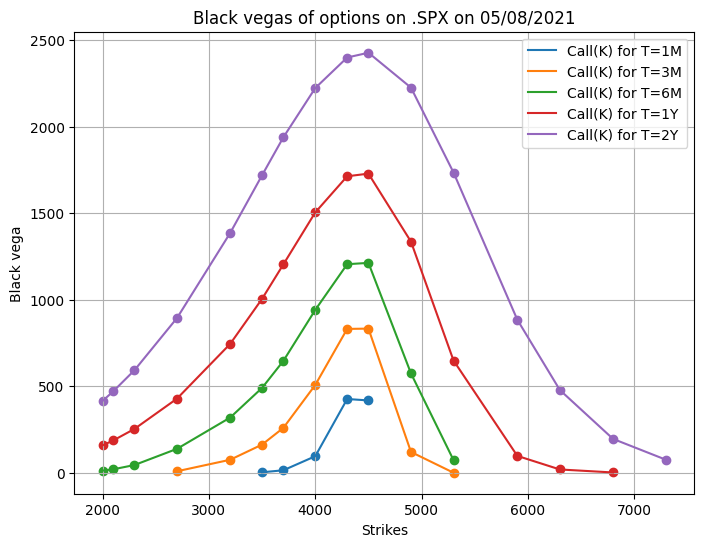

In [19]:
plt.figure(figsize=(8, 6))
periods_to_plot = ["1M", "3M", "6M", "1Y", "2Y"]
expirations = np.array([1, 3, 6, 12, 24]) / 12
for i, period_to_plot in enumerate(periods_to_plot):
    selected_strikes, selected_vols = get_strikes_and_vols_per_period(period=period_to_plot, volatilities=volatilities, strikes=strikes, periods=periods)

    index_of_period = np.where(periods == period_to_plot)[0][0]
    date = dates[index_of_period]
    forward, df = forwards[date], dfs[date]
    expiration = expirations[i]
    
    vegas = black_vega(F=forward, K=selected_strikes, T=expiration, sigma=selected_vols, df=df)

    plt.scatter(selected_strikes, vegas)
    plt.plot(selected_strikes, vegas, label="Call(K) for T={}".format(period_to_plot))

plt.title("Black vegas of options on .SPX on {}".format(value_date))
plt.xlabel("Strikes")
plt.ylabel("Black vega")
plt.grid()
plt.legend()
plt.show()

##### 2.3 Skew $\dfrac{\partial \sigma(K)}{\partial K}$

In [20]:
def skew(implied_volatility_curve: Callable[[], Any], 
         built_in_method: bool = True, 
         argument: Union[float, None] = None,
         shift: Union[float, None] = None,
         is_relative: bool = True):
    """
    Evaluates the skew \dfrac{\partial \sigma(K)}{\partial K} from given implied volatility curve.

    Args:
        implied_volatility_curve: implied volatility curve \sigma(K).
        built_in_method: if True, .derivative() is used, otherwise finite difference is applied.      
    """
    if built_in_method:
        return implied_volatility_curve.derivative()
    else:
        shifted_arg_up = argument * (1 + shift) if is_relative else argument + shift
        shifted_arg_down = argument * (1 - shift) if is_relative else argument - shift
        denominator = 2 * argument * shift if is_relative else 2 * shift
        return (implied_volatility_curve(shifted_arg_up) -  implied_volatility_curve(shifted_arg_down)) / denominator

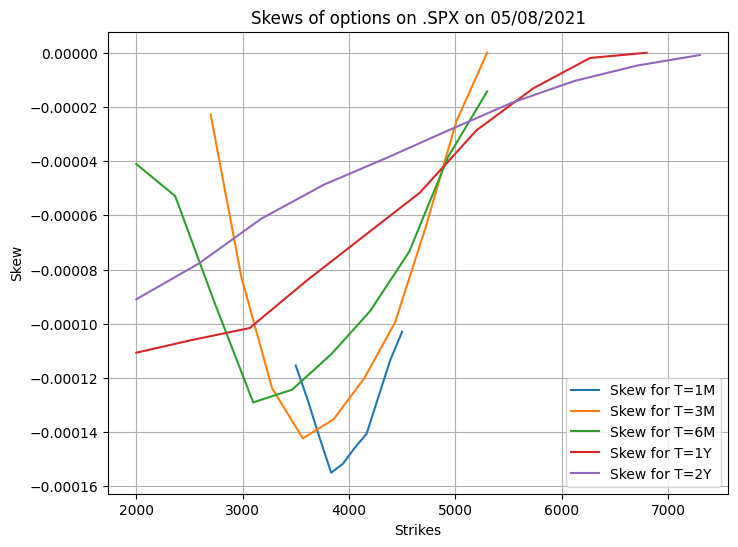

In [21]:
plt.figure(figsize=(8, 6))
periods_to_plot = ["1M", "3M", "6M", "1Y", "2Y"]
expirations = np.array([1, 3, 6, 12, 24]) / 12
for i, period_to_plot in enumerate(periods_to_plot):
    selected_strikes, selected_vols = get_strikes_and_vols_per_period(period=period_to_plot, volatilities=volatilities, strikes=strikes, periods=periods)
    vol_interpolator = volatility_interpolator(strikes=selected_strikes, volatilities=selected_vols) # monotone cubic splines interpolator
    vol_skew = skew(implied_volatility_curve=vol_interpolator, built_in_method=True)

    strike_min, strike_max = np.min(selected_strikes), np.max(selected_strikes)
    high_frequency_strikes_grid = np.linspace(strike_min, strike_max, 10)

    plt.plot(high_frequency_strikes_grid, vol_skew(np.log(high_frequency_strikes_grid)) / high_frequency_strikes_grid, label="Skew for T={}".format(period_to_plot))

plt.title("Skews of options on .SPX on {}".format(value_date))
plt.xlabel("Strikes")
plt.ylabel("Skew")
plt.grid()
plt.legend()
plt.show()

##### 2.4 Pricing digital option

Here we compare three different approaches to pricing digitals: 

$$
\begin{align*}
PV^{\text{Call spread}} &= - \dfrac{dC(K, \sigma(K))}{dK} \approx - \dfrac{C\left( K \cdot (1 + \varepsilon), \sigma(K \cdot (1 + \varepsilon)) \right) - C\left(K \cdot (1 - \varepsilon), \sigma(K \cdot (1 - \varepsilon))\right)}{2 \cdot \varepsilon \cdot K}, \\ \\ 
PV^{\text{Call spread expansion}} &= \text{Black}^{digital}(K) - \nu_{Black}(K, \sigma(K)) \cdot \text{Skew}(K) \\
&\approx \text{Black}^{digital}(K) - \nu_{Black}(K, \sigma(K)) \cdot \dfrac{\sigma(K \cdot (1 + \varepsilon)) - \sigma(K \cdot (1 - \varepsilon))}{2 \cdot \varepsilon \cdot K}, \\ \\
PV^{\text{Black digital}} &= \text{Black}^{digital}(K). \\ \\
\end{align*}
$$

First two approaches should give the same the results as they are numerical approximations of the same functions, whereas the third one is not. 

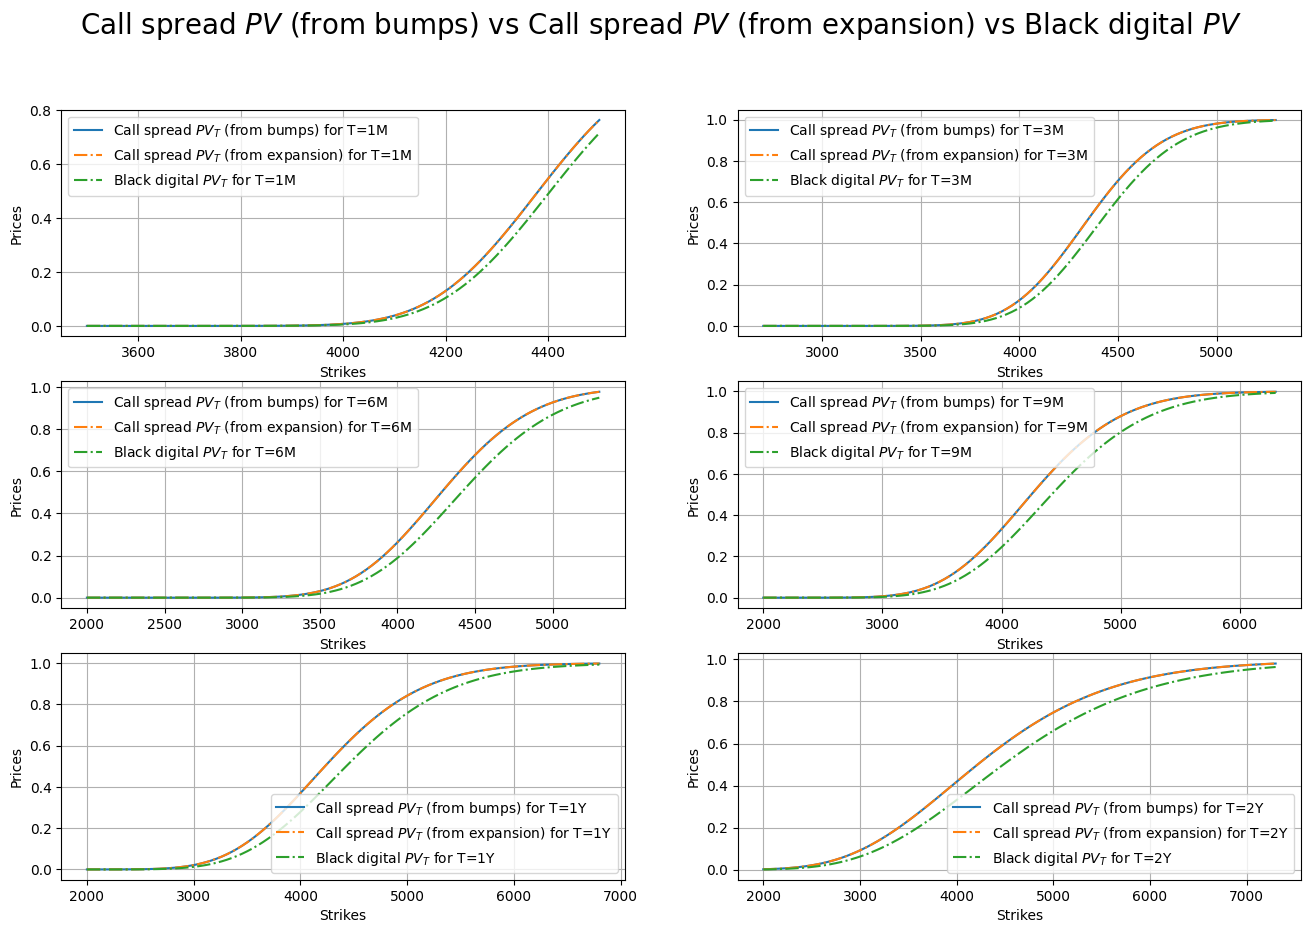

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(16, 10))
periods_to_plot = ["1M", "3M", "6M", "9M", "1Y", "2Y"]
expirations = np.array([1, 3, 6, 9, 12, 24]) / 12
digital_call_prices_from_bumps = []
digital_call_prices_from_expansion = []
digital_call_prices_in_black_scholes = []

for i, period_to_plot in enumerate(periods_to_plot):
    selected_strikes, selected_vols = get_strikes_and_vols_per_period(period=period_to_plot, volatilities=volatilities, strikes=strikes, periods=periods)

    index_of_period = np.where(periods == period_to_plot)[0][0]
    date = dates[index_of_period]
    forward, df = forwards[date], dfs[date]
    expiration = expirations[i]

    digital_option_strike = forward # consider the Digital with strike K at the forward F
    epsilon = 1e-8 # relative shift of given strike
    digital_call_strike_up_shift = digital_option_strike * (1 + epsilon) # strikes bumped upward
    digital_call_strike_down_shift = digital_option_strike * (1 - epsilon) # strikes  bumped downward

    vol_interpolator = volatility_interpolator(strikes=selected_strikes, volatilities=selected_vols) # monotone cubic splines interpolator
    strike_min, strike_max = np.min(selected_strikes), np.max(selected_strikes) # min and max strikes
    high_frequency_strikes_grid = np.linspace(strike_min, strike_max, 100) 

    # Extract volatilities corresponding to K, K * (1 + ε) and K * (1 - ε) strikes
    digital_call_strike_vol = float(vol_interpolator(np.log(digital_option_strike))) # vol at K = F
    digital_call_strike_up_shift_vol = float(vol_interpolator(np.log(digital_call_strike_up_shift))) # vol at K = F * (1 + ε)
    digital_call_strike_down_shift_vol = float(vol_interpolator(np.log(digital_call_strike_down_shift))) # vol at K = F * (1 - ε)

    digital_call_price_from_bumps_per_given_period = []
    digital_call_prices_from_expansion_per_given_period = []
    digital_call_prices_in_black_sholes_per_given_period = []
    
    # Iterate over all possible forwards
    for f in high_frequency_strikes_grid: 
        # Price the Call with  K * (1 - ε) strike and corresponding implied volatility level
        call_price_down_shift = black_price_formula(F=f, K=digital_call_strike_down_shift, 
                                                    T=expiration, sigma=digital_call_strike_down_shift_vol, 
                                                    isCall=True, df=df) # Black(F=f, K=F*(1+ε), σ(T,F*(1+ε)))
        # Price the Call with  K * (1 + ε) strike and corresponding implied volatility level
        call_price_up_shift = black_price_formula(F=f, K=digital_call_strike_up_shift, 
                                                  T=expiration, sigma=digital_call_strike_up_shift_vol, 
                                                  isCall=True, df=df) # Black(F=f, K=F*(1-ε), σ(T,F*(1-ε)))
        
        # Approximate the deriavetive - dC(K)/dK as (C(K * (1 - ε)) - C(K * (1 + ε))) / (2 * K * ε)
        delta_from_approximation = (call_price_down_shift - call_price_up_shift) / (2 * epsilon * digital_option_strike) # derivative approximation of -dC(k)/dk
        digital_call_price_from_bumps_per_given_period.append(delta_from_approximation)
        
        # Compute the Black's digital price, vega and skew.
        black_scholes_price = black_digital(F=f, K=digital_option_strike, T=expiration, sigma=digital_call_strike_vol, isCall=True, df=df)
        black_scholes_vega = black_vega(F=f, K=digital_option_strike, T=expiration, sigma=digital_call_strike_vol, df=df)
        effective_skew = skew(implied_volatility_curve=vol_interpolator, built_in_method=False, argument=np.log(digital_option_strike),
                              shift=1e-8, is_relative=True)
        digital_call_prices_from_expansion_per_given_period.append(black_scholes_price - black_scholes_vega * effective_skew / digital_option_strike) 
        digital_call_prices_in_black_sholes_per_given_period.append(black_scholes_price) 

    digital_call_prices_from_bumps.append(digital_call_price_from_bumps_per_given_period)
    digital_call_prices_from_expansion.append(digital_call_prices_from_expansion_per_given_period)
    digital_call_prices_in_black_scholes.append(digital_call_prices_in_black_sholes_per_given_period)

    col = i % 2
    row = int((i - col) / 2)
    axs[row, col].plot(high_frequency_strikes_grid, digital_call_price_from_bumps_per_given_period, label="Call spread $PV_T$ (from bumps) for T={}".format(period_to_plot))
    axs[row, col].plot(high_frequency_strikes_grid, digital_call_prices_from_expansion_per_given_period, label="Call spread $PV_T$ (from expansion) for T={}".format(period_to_plot), linestyle="-.")
    axs[row, col].plot(high_frequency_strikes_grid, digital_call_prices_in_black_sholes_per_given_period, label="Black digital $PV_T$ for T={}".format(period_to_plot), linestyle="-.")
    axs[row, col].set_xlabel("Strikes")
    axs[row, col].set_ylabel("Prices")
    axs[row, col].grid(True)
    axs[row, col].legend()
    
fig.suptitle('Call spread $PV$ (from bumps) vs Call spread $PV$ (from expansion) vs Black digital $PV$', fontsize=20)
plt.show()

### References

1. Black, Fischer, (1976), The pricing of commodity contracts, *Journal of Financial Economics*, 3, issue 1-2, p. 167-179.